In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib widget

# SR830 Code samples

In [2]:
from pymeasure.instruments.srs import SR830

lockin = SR830('GPIB2::25::INSTR')
# lockin.write('FAST2')
# lockin.sample_frequency = 512
# print(f'lockin sample freq is={lockin.sample_frequency}')
# lockin.reset_buffer()
# lockin.start_buffer()
# lockin.wait_for_buffer(count = lockin.sample_frequency*10)
# print(lockin.buffer_count)



In [10]:
lockin.xy

[4.91145e-05, 0.0014701]

In [11]:
# # lockin.values(f'TRCA?1,0, {lockin.buffer_count}', )
# # lockin.binary_values(f'TRCB?1,0, {lockin.buffer_count}')
# # xbuffer, ybuffer = lockin.get_buffer_binary(1), lockin.get_buffer_binary(2)
# # print(xbuffer.mean(), xbuffer.std())
# # print(ybuffer.mean(), ybuffer.std())
# # lockin.binary_values(f'TRCB?1,0,{lockin.buffer_count}')

# lockin.write('FAST1')
# xbuffer = np.array(lockin.get_buffer_float(channel = 1))
# ybuffer = np.array(lockin.get_buffer_float(channel = 2))
# print(xbuffer.mean(), xbuffer.std())
# print(ybuffer.mean(), ybuffer.std())

In [5]:
# lockin.ask('n')


In [6]:
print(lockin.SAMPLE_FREQUENCIES)
lockin.time_constant = 0.1

[0.0625, 0.125, 0.25, 0.5, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512]


lockin sample freq is=16
160


(array([ 1.,  5.,  0., 17.,  0., 47., 55.,  0., 16., 19.]),
 array([0.00146867, 0.00146881, 0.00146895, 0.00146909, 0.00146924,
        0.00146938, 0.00146952, 0.00146967, 0.00146981, 0.00146995,
        0.0014701 ]),
 <BarContainer object of 10 artists>)

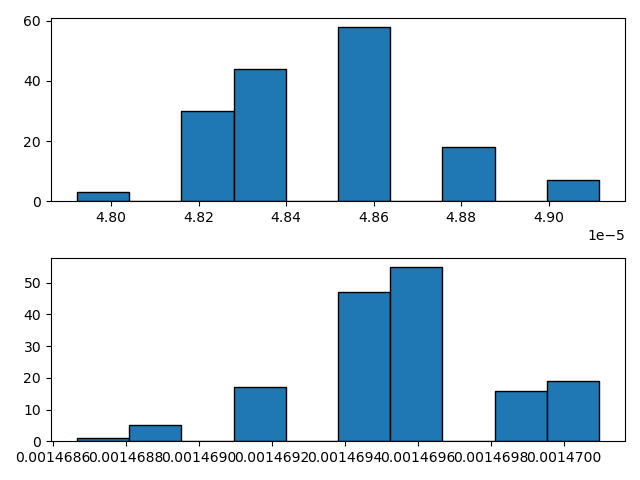

In [16]:
lockin.id
lockin.sample_frequency = 16
print(f'lockin sample freq is={lockin.sample_frequency}')
lockin.reset_buffer()
lockin.start_buffer()
lockin.wait_for_buffer(count = 10*lockin.sample_frequency)
print(lockin.buffer_count)
# xbuffer =lockin.get_buffer_binary(1)
# ybuffer= lockin.get_buffer_binary(2)
# lockin.write(f'TRCB?1,0,{lockin.buffer_count}')
# # lockin.read_binary_values()
# bytes =lockin.read_bytes(count =-1)
# np.frombuffer(bytes[0:], dtype = np.float32)

xbuffer = lockin.get_buffer_float(channel = 1)
ybuffer = lockin.get_buffer_float(channel = 2)
fig, [axa, axb] = plt.subplots(2, 1, tight_layout=True)
axa.hist(xbuffer, edgecolor = 'k')
axb.hist(ybuffer, edgecolor = 'k')

In [8]:
%load_ext cython

%%cython 

cpdef int square(int x):
    return x * x



SyntaxError: invalid syntax (Temp/ipykernel_2572/884934064.py, line 5)

In [244]:
# lockin.write(f'TRCA?1,0,{lockin.buffer_count}')
# # time.sleep(5)
# xbuffer_str = lockin.read()
# xbuffer_str = lockin.ask(f'TRCA?1,0,{lockin.buffer_count}',)
# xbuffer_str

# lockin.write(f'TRCB?1,0,{lockin.buffer_count}')
# # time.sleep(5)
# xbuffer_str = lockin.read_bytes(-1)

In [245]:
# # xbuffer =lockin.get_buffer_binary(1)
# # ybuffer = lockin.get_buffer_binary(2)



In [246]:
# lockin.sample_frequency = 512
# print(f'lockin sample freq is={lockin.sample_frequency}')
# lockin.reset_buffer()
# lockin.start_buffer()
# lockin.wait_for_buffer(count = lockin.sample_frequency*10)
# print(lockin.buffer_count)
# lockin.write(f'TRCA?1,0,{lockin.buffer_count}')
# lockin.read()

(array([24.,  0.,  0.,  0.,  0., 93.,  0.,  0.,  0., 11.]),
 array([0.00144292, 0.00144294, 0.00144296, 0.00144299, 0.00144301,
        0.00144304, 0.00144306, 0.00144308, 0.00144311, 0.00144313,
        0.00144316]),
 <BarContainer object of 10 artists>)

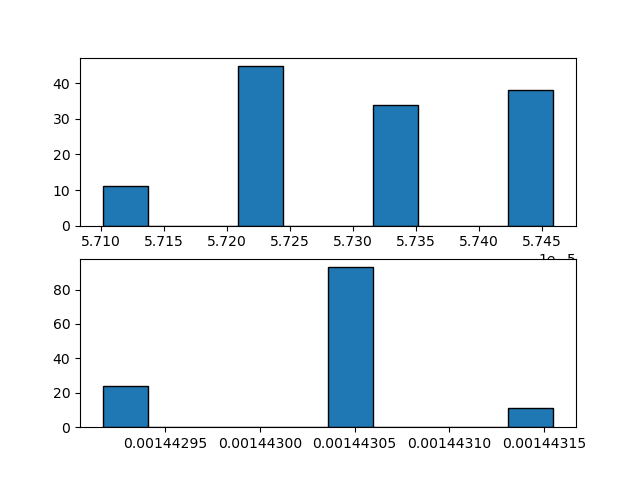

In [197]:
lockin.write('FAST0;STRD')

In [ ]:
import zhinst.core

In [ ]:
device_id = "dev4934" # Device serial number available on its rear panel.
interface = "1GbE" # For Ethernet connection or when MFLI/MFIA is connected to a remote Data Server.
# interface = "USB" # For all instruments connected to the host computer via USB except MFLI/MFIA.
#interface = "PCIe" # For MFLI/MFIA devices in case the Data Server runs on the device.

# server_host = "localhost"
server_host = '127.0.0.1'
# server_host = "192.168.77.26"
server_port = 8004

#server_port = 8005 # Default port for HF2LI.
api_level = 6 # Maximum API level supported for all instruments except HF2LI.
#api_level = 1 # Maximum API level supported for HF2LI.

# Create an API session to the Data Server.
daq = zhinst.core.ziDAQServer(server_host, server_port, api_level)
# Establish a connection between Data Server and Device.
daq.connectDevice(device_id, interface)

In [ ]:
demod_path = f"/{device_id}/demods/0/"
sample_path = demod_path+'sample'

daq.getSample(sample_path)

{'timestamp': array([227384699796142], dtype=uint64),
 'x': array([-7.57581736e-10]),
 'y': array([7.82990742e-10]),
 'frequency': array([732.9999999]),
 'phase': array([3.37437424]),
 'dio': array([0], dtype=uint32),
 'trigger': array([512], dtype=uint32),
 'auxin0': array([0.00131781]),
 'auxin1': array([0.])}

In [ ]:
daq.setDouble('dev4934/oscs/0/freq', 734)



In [ ]:
'/dev4934/demods/0/sample.R'

'/dev4934/demods/0/sample.R'

In [ ]:
daq.getSample(demod_path+'sample')


{'timestamp': array([227374896695982], dtype=uint64),
 'x': array([1.72026712e-09]),
 'y': array([-1.18313107e-09]),
 'frequency': array([732.9999999]),
 'phase': array([2.07413377]),
 'dio': array([0], dtype=uint32),
 'trigger': array([768], dtype=uint32),
 'auxin0': array([0.00164727]),
 'auxin1': array([-0.00098523])}

In [ ]:
display(daq.listNodes(demod_path))
display(daq.getSample(sample_path))

['/dev4934/demods/0/adcselect',
 '/dev4934/demods/0/order',
 '/dev4934/demods/0/rate',
 '/dev4934/demods/0/oscselect',
 '/dev4934/demods/0/harmonic',
 '/dev4934/demods/0/phaseshift',
 '/dev4934/demods/0/sinc',
 '/dev4934/demods/0/bypass',
 '/dev4934/demods/0/timeconstant',
 '/dev4934/demods/0/enable',
 '/dev4934/demods/0/freq',
 '/dev4934/demods/0/trigger',
 '/dev4934/demods/0/phaseadjust',
 '/dev4934/demods/0/sample']

{'timestamp': array([227375330610862], dtype=uint64),
 'x': array([-6.90321325e-10]),
 'y': array([-1.45805114e-09]),
 'frequency': array([732.9999999]),
 'phase': array([2.03300391]),
 'dio': array([0], dtype=uint32),
 'trigger': array([256], dtype=uint32),
 'auxin0': array([0.00098836]),
 'auxin1': array([-0.00065682])}

In [ ]:
daq.getSample('/dev4934/demods/0/sample')

{'timestamp': array([227375541708462], dtype=uint64),
 'x': array([-5.79671162e-10]),
 'y': array([2.92274571e-09]),
 'frequency': array([732.9999999]),
 'phase': array([1.46130845]),
 'dio': array([0], dtype=uint32),
 'trigger': array([768], dtype=uint32),
 'auxin0': array([0.]),
 'auxin1': array([-0.00164204])}

In [ ]:
# daq.setDouble(f'/{device_id}/sigouts/0/range',12E-3)



In [ ]:
'{:}'.format(3)

'3'

In [ ]:
import datetime as dt
dt.datetime.utcnow().timestamp()

1686521581.199947

# zi_MFLI class

In [ ]:
from importlib import reload
import zurich_MFLI as zur_driver
reload(zur_driver)

daq_obj = zur_driver.zi_MFLI(device_id, interface, server_host, server_port, api_level)

In [ ]:
display(daq_obj.get_XY())
display(daq_obj.get_freq())

[array([7.05867046e-06]), array([2.38378174e-07])]

array([32764.49999994])

In [ ]:
daq_obj.set_freq(32764.51)
daq_obj.get_freq()

array([32764.51000005])